In [41]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import sqlite3
import logging
import time
import warnings
warnings.filterwarnings('ignore')

logging.basicConfig(
    filename = 'logs/ingestion_db.log',
    level= logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s ",
    filemode="a"
)

engine = create_engine('sqlite:///inventory.db')
def ingest_db(df,table_name,engine):
    '''this function will ingest the dataframe into database table'''
    df.to_sql(table_name,con=engine,if_exists='replace',index=False)

def load_raw_data():
    '''this function will load CSV as dataframe and ingest into db'''
    start = time.time()
    for file in os.listdir('data'):
        if '.csv' in file:
            df = pd.read_csv('data/'+file)
            logging.info(f"Ingesting {file} in db")
            ingest_db(df,'bmw',engine)
    end = time.time()
    total_time = (end-start)/60
    logging.info('--------------Ingestion Complete--------------')
    logging.info(f'Total Time Taken: {total_time} minutes ')

if __name__ == '__main__':
    load_raw_data()

In [6]:
df.shape

(50000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model                 50000 non-null  object 
 1   Year                  50000 non-null  int64  
 2   Region                50000 non-null  object 
 3   Color                 50000 non-null  object 
 4   Fuel_Type             50000 non-null  object 
 5   Transmission          50000 non-null  object 
 6   Engine_Size_L         50000 non-null  float64
 7   Mileage_KM            50000 non-null  int64  
 8   Price_USD             50000 non-null  int64  
 9   Sales_Volume          50000 non-null  int64  
 10  Sales_Classification  50000 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 4.2+ MB


In [6]:
df.describe()

,Year,Engine_Size_L,Mileage_KM,Price_USD,Sales_Volume
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2017.015700,3.247180,100307.203140,75034.600900,5067.514680
std,4.324459,1.009078,57941.509344,25998.248882,2856.767125
min,2010.000000,1.500000,3.000000,30000.000000,100.000000
25%,2013.000000,2.400000,50178.000000,52434.750000,2588.000000
50%,2017.000000,3.200000,100388.500000,75011.500000,5087.000000
75%,2021.000000,4.100000,150630.250000,97628.250000,7537.250000
max,2024.000000,5.000000,199996.000000,119998.000000,9999.000000


In [9]:
conn = sqlite3.connect('inventory.db')

In [10]:
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type = 'table'",conn)

,name
0,bmw


### Which model has the highest Sales?

In [71]:
total_sales = pd.read_sql_query("""
                        SELECT Model, SUM(Sales_Volume) AS qty
                        FROM bmw
                        GROUP BY Model
                        ORDER BY qty DESC
                        """,conn)
total_sales

,Model,qty
0,7 Series,23786466
1,i8,23423891
2,X1,23406060
3,3 Series,23281303
4,i3,23133849
5,5 Series,23097519
6,M5,22779688
7,X3,22745529
8,X5,22709749
9,X6,22661986


### Which model generates high revenue?

In [72]:
total_revenue = pd.read_sql_query("""
                    SELECT Model, SUM(Price_USD) AS total
                    FROM bmw
                    GROUP BY Model
                    ORDER BY total DESC                    
                        """,conn)
total_revenue

,Model,total
0,7 Series,352610538
1,3 Series,347226845
2,i8,347137044
3,5 Series,345721780
4,i3,345427638
5,X1,343948341
6,X3,337349726
7,X5,335215320
8,M5,333498741
9,X6,333318141


In [14]:
def value_change(value):
    if value>=1_000_000:
        return f'{value/1_000_000:.2f}M'
    else:
        return str(value)

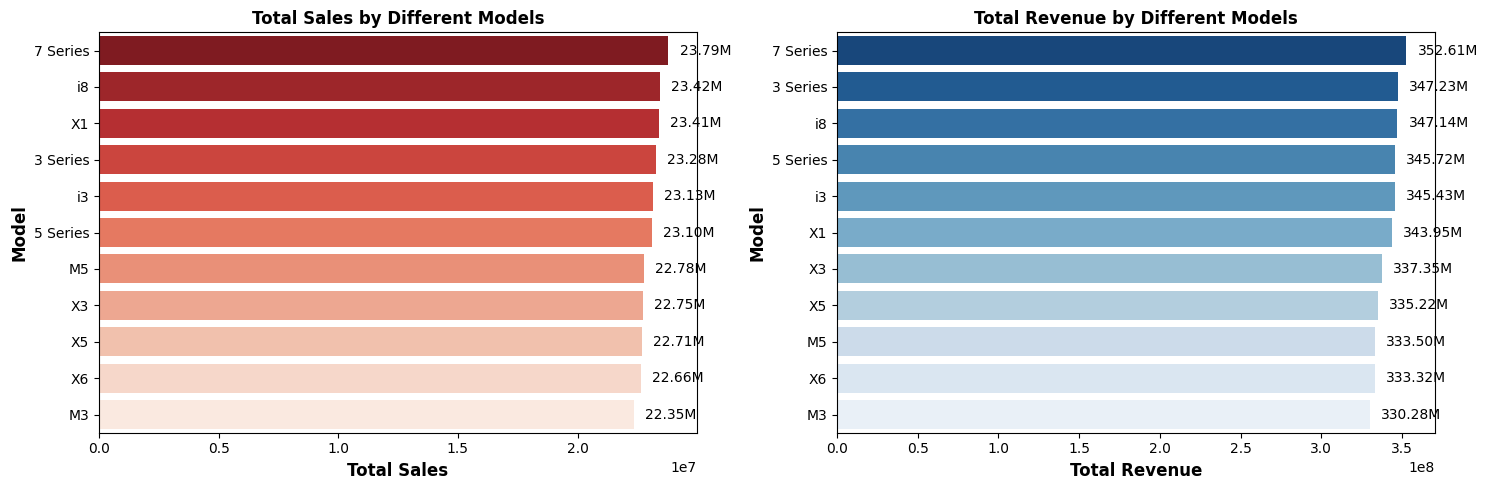

In [77]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.barplot(total_sales,x='qty',y='Model',palette='Reds_r')
plt.title("Total Sales by Different Models",fontdict={'size':12,'weight':'bold'})
plt.xlabel("Total Sales",fontsize=12,fontweight='bold')
plt.ylabel("Model",fontsize=12,fontweight='bold')

for bar in ax.patches:
    ax.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)

plt.subplot(1,2,2)
ax1 = sns.barplot(total_revenue,x='total',y='Model',palette='Blues_r')
plt.title("Total Revenue by Different Models",fontdict={'size':12,'weight':'bold'})
plt.xlabel("Total Revenue",fontsize=12,fontweight='bold')
plt.ylabel("Model",fontsize=12,fontweight='bold')

for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)

plt.tight_layout()    
plt.show()

- 7 Series is the highest sale and highest revenue generated model in the list.
- M3 Series is the lowest sale and lowest revenue generated model in the list.

### Who is the top model in terms of highest mileage?

In [56]:
pd.read_sql_query("""
                SELECT Model, ROUND(AVG(Mileage_KM),2) AS mileage
                FROM bmw
                GROUP BY Model
                ORDER BY mileage DESC
                """,conn)

,Model,mileage
0,M5,102343.00
1,5 Series,101356.63
2,7 Series,100792.17
3,X3,100716.87
4,X1,100375.68
5,X5,100259.74
6,3 Series,100159.90
7,M3,99729.77
8,X6,99482.41
9,i8,99447.38


- M5 Model is the highest mileage model across all models.

### Which region has the highest sales?

In [35]:
region_sales = pd.read_sql_query("""
                    SELECT Region, SUM(Sales_Volume) AS total
                    FROM bmw
                    GROUP BY Region
                    ORDER BY total DESC
                    """,conn)
region_sales

,Region,total
0,Asia,42974277
1,Europe,42555138
2,North America,42402629
3,Middle East,42326620
4,Africa,41565252
5,South America,41551818


### Which model has highest sales in each region?

In [60]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Region, Model, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Region ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Region, Model)
                    SELECT Region, Model, total
                    FROM table1
                    WHERE rn = 1
                    """,conn)

,Region,Model,total
0,Africa,5 Series,4020702
1,Asia,X1,4192289
2,Europe,i8,4202401
3,Middle East,7 Series,4080751
4,North America,7 Series,4087259
5,South America,X6,4023804


- 7 Series is the top selling model in Middle East and North America.
- 5 Series is in Africa.
- X1 is in Asia.
- i8 is in Europe.
- X6 is in South America.

### Which region generates high revenue?

In [36]:
region_rev = pd.read_sql_query("""
                    SELECT Region, SUM(Price_USD) AS total
                    FROM bmw
                    GROUP BY Region
                    ORDER BY total DESC
                        """,conn)
region_rev

,Region,total
0,Asia,638741336
1,North America,625708906
2,Middle East,625687400
3,Europe,624952966
4,South America,618607164
5,Africa,618032273


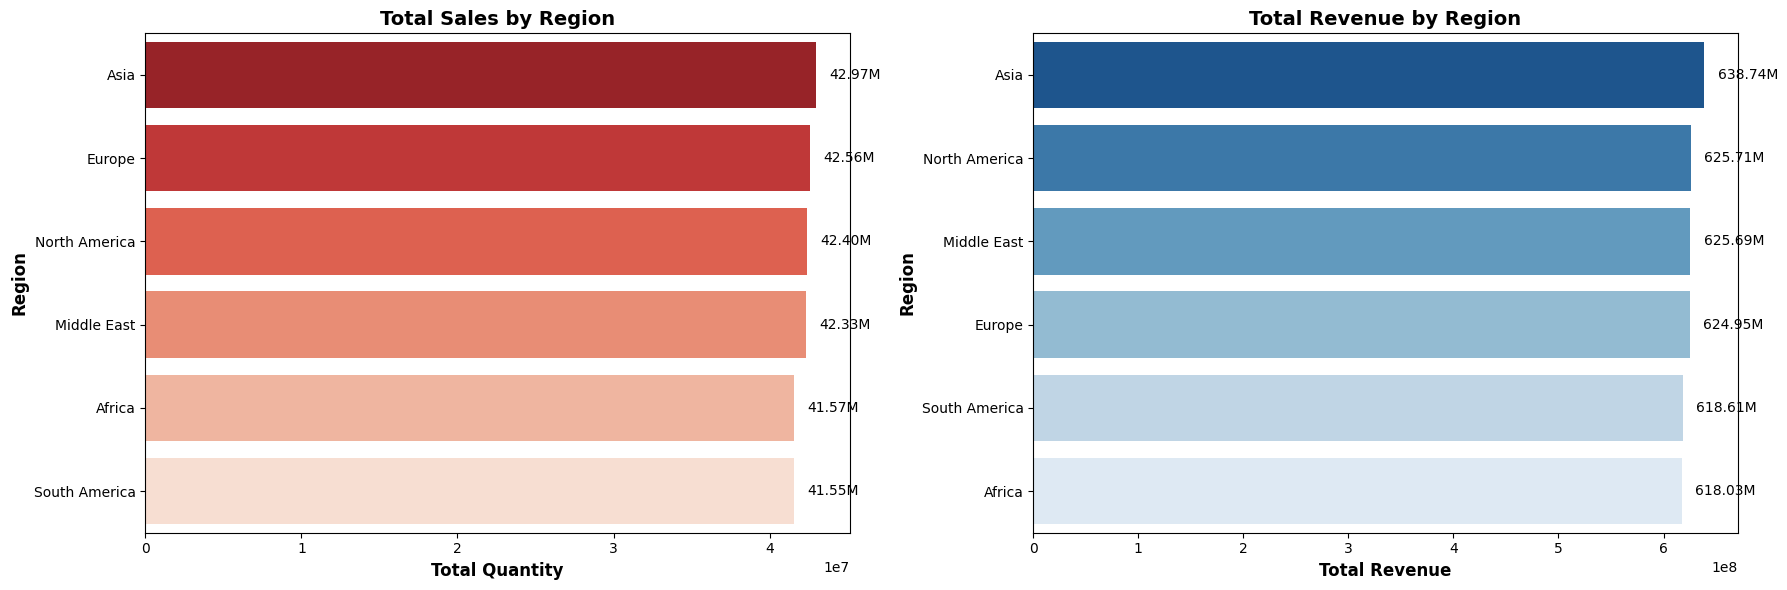

In [42]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
ax = sns.barplot(region_sales,x='total',y='Region',palette='Reds_r')
plt.title("Total Sales by Region",fontdict={'weight':'bold','size':14})
plt.xlabel("Total Quantity",fontsize=12,fontweight='bold')
plt.ylabel("Region",fontsize=12,fontweight='bold')

for bar in ax.patches:
    ax.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)

plt.subplot(1,2,2)
ax = sns.barplot(region_rev,x='total',y='Region',palette='Blues_r')
plt.title("Total Revenue by Region",fontdict={'weight':'bold','size':14})
plt.xlabel("Total Revenue",fontsize=12,fontweight='bold')
plt.ylabel("Region",fontsize=12,fontweight='bold')

for bar in ax.patches:
    ax.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)

plt.tight_layout()
plt.show()

- Asia has highest sales and revenue out of all continent.

### Which Fuel Type generates high sales?

In [54]:
pd.read_sql_query("""
                    SELECT Fuel_Type, SUM(Sales_Volume) AS total
                    FROM bmw
                    GROUP BY Fuel_Type
                    ORDER BY total DESC
                    """,conn)

,Fuel_Type,total
0,Hybrid,64532097
1,Petrol,63324154
2,Electric,63157665
3,Diesel,62361818


- Hybrid Fuel is highly demanded out of all four fuels model.

In [59]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Fuel_Type, Model, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Fuel_Type ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Fuel_Type, Model)
                    SELECT Fuel_Type, Model, total
                    FROM table1
                    WHERE rn = 1
                    """,conn)

,Fuel_Type,Model,total
0,Diesel,7 Series,6092302
1,Electric,X1,6028920
2,Hybrid,7 Series,6195538
3,Petrol,5 Series,5971944


- 7 Series is the Top selling model in Diesel and Hybrid Model.
- X1 Series is in Electric Fuel Model.
- 5 Series is in Petrol Fuel Model.

### Which fuel type is highly demanded in each region?

In [43]:
pd.read_sql_query("""
                    SELECT Region,
                    SUM(CASE WHEN Fuel_Type = 'Diesel' THEN Sales_Volume ELSE 0 END) AS Diesel,
                    SUM(CASE WHEN Fuel_Type = 'Petrol' THEN Sales_Volume ELSE 0 END) AS Petrol,
                    SUM(CASE WHEN Fuel_Type = 'Hybrid' THEN Sales_Volume ELSE 0 END) AS Hybrid,
                    SUM(CASE WHEN Fuel_Type = 'Electric' THEN Sales_Volume ELSE 0 END) AS Electric
                    FROM bmw
                    GROUP BY Region
                    """,conn)

,Region,Diesel,Petrol,Hybrid,Electric
0,Africa,10211670,10538463,10486034,10329085
1,Asia,10492033,10462998,11422396,10596850
2,Europe,10406133,10733279,10825662,10590064
3,Middle East,10491957,10812148,10627320,10395195
4,North America,10259904,10472845,10808682,10861198
5,South America,10500121,10304421,10362003,10385273


- Africa prefers Petrol Model.
- Asia prefers Hybrid Model.
- Europe prefers Hybrid Model.
- Middle East prefers Petrol Model.
- North America prefers Electric Model.
- South America preferes Diesel Model.

### Which transmission has total Sales?

In [61]:
pd.read_sql_query("""
                    SELECT Transmission, SUM(Sales_Volume) AS total
                    FROM bmw
                    GROUP BY Transmission
                    ORDER BY total DESC
                    """,conn)

,Transmission,total
0,Manual,127362077
1,Automatic,126013657


### How much sales has each transmission in each region?

In [45]:
pd.read_sql_query("""
                    SELECT Region,
                    SUM(CASE WHEN Transmission = 'Automatic' THEN Sales_Volume ELSE 0 END) AS Automatic,
                    SUM(CASE WHEN Transmission = 'Manual' THEN Sales_Volume ELSE 0 END) AS Manual
                    FROM bmw
                    GROUP BY Region
                    """,conn)

,Region,Automatic,Manual
0,Africa,20637260,20927992
1,Asia,21646739,21327538
2,Europe,21086212,21468926
3,Middle East,21025867,21300753
4,North America,21329746,21072883
5,South America,20287833,21263985


- Africa prefers Manual Transmission.
- Asia prefers Automatic Transmission.
- Europe prefers Manual Transmission.
- Middle East prefers Manual Transmission.
- North America pefers Automatic Transmission.
- South America prefers Manual Transmission.

In [64]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Transmission, Model, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Transmission ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Transmission, Model)
                    SELECT Transmission, Model, total
                    FROM table1
                    WHERE rn = 1
                    """,conn)

,Transmission,Model,total
0,Automatic,X1,11870986
1,Manual,7 Series,11997017


- X1 is the top selling model in Automatic Transmission.
- 7 Series is the top selling model in Manual Transmission.

In [69]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Region, Transmission, Model, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Region ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Region, Transmission, Model)
                    SELECT Region, Transmission, Model, total
                    FROM table1
                    WHERE rn = 1                    
                    """,conn)

,Region,Transmission,Model,total
0,Africa,Manual,X5,2077419
1,Asia,Manual,X1,2099183
2,Europe,Manual,i8,2185292
3,Middle East,Manual,7 Series,2201278
4,North America,Automatic,i8,2107133
5,South America,Manual,X6,2090181


- In Africa X5 Model in Manual Transmission has highest sale.
- In Asia X1 Model in Manual Transmission has highest sale.
- In Europe i8 Model in Manual Transmission has highest sale.
- In Middle East 7 Series Model in Manual Transmission has highest sale.
- In North America i8 Model in Automatic Transmission has highest sale.
- In South America X6 Model in Manual Transmission has highest sale.

### Which engine has generated most sales?

In [46]:
pd.read_sql_query("""
                SELECT Engine_Size_L, SUM(Sales_Volume) AS total
                FROM bmw
                GROUP BY Engine_Size_L
                ORDER BY total DESC
                LIMIT 5
                """,conn)

,Engine_Size_L,total
0,1.9,7667354
1,4.5,7657060
2,3.8,7573254
3,2.5,7560056
4,3.2,7495239


1.9L is Highly Selling Engine Model in all Engines followed by 4.5L Engine Model.

In [47]:
pd.read_sql_query("""
                SELECT Region, SUM(Sales_Volume) AS total_sales
                FROM bmw
                WHERE Engine_Size_L = '1.9'
                GROUP BY Region
                ORDER BY total_sales DESC
                """,conn)

,Region,total_sales
0,Europe,1469877
1,Africa,1337887
2,South America,1309434
3,Asia,1255564
4,Middle East,1220593
5,North America,1073999


- Europe is the largest continent of 1.9L Engine Model Seller.

In [49]:
pd.read_sql_query("""
                SELECT Model, SUM(Sales_Volume) AS total_sales
                FROM bmw
                WHERE (Engine_Size_L = '1.9') & (Region = 'Europe')
                GROUP BY Model
                ORDER BY total_sales DESC
                LIMIT 5
                """,conn)

,Model,total_sales
0,X6,221879
1,M5,195035
2,X1,146973
3,5 Series,141223
4,X3,140884


- X6 and M5 Models of 1.9L Engine are higher in demand more than any model in Europe.

In [50]:
pd.read_sql_query("""
                SELECT Region, SUM(Sales_Volume) AS total_sales
                FROM bmw
                WHERE Engine_Size_L = '4.5'
                GROUP BY Region
                ORDER BY total_sales DESC
                """,conn)

,Region,total_sales
0,Asia,1404718
1,Africa,1316399
2,North America,1300207
3,Middle East,1255674
4,South America,1214389
5,Europe,1165673


- Asia is the largest continent of 4.5L Engine seller.

In [53]:
pd.read_sql_query("""
                SELECT Model, SUM(Sales_Volume) AS total_sales
                FROM bmw
                WHERE (Engine_Size_L = '4.5') & (Region = 'Asia')
                GROUP BY Model
                ORDER BY total_sales DESC
                LIMIT 5
                """,conn)

,Model,total_sales
0,7 Series,188220
1,X1,167649
2,i8,152826
3,M5,131387
4,M3,130111


- 7 Series and X1 Models are highly demanded 4.5L Engine in Asia.

### Which color is highly demanded?

In [5]:
pd.read_sql_query("""
                    SELECT Color, SUM(Sales_Volume) AS total
                    FROM bmw
                    GROUP BY Color
                    ORDER BY total DESC
                    """,conn)

,Color,total
0,Red,42750183
1,Silver,42674022
2,White,42272954
3,Grey,41995141
4,Blue,41972741
5,Black,41710693


- Red Color is highly preferable in all color. 

In [9]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Color, Model, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Color ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Color, Model)
                    SELECT Color, Model, total, rn
                    FROM table1
                    WHERE rn = 1
                    """,conn)

,Color,Model,total,rn
0,Black,7 Series,4122055,1
1,Blue,3 Series,4087583,1
2,Grey,7 Series,4036445,1
3,Red,X1,4095996,1
4,Silver,3 Series,4299659,1
5,White,M5,4074731,1


### Which year generates high sales?

In [19]:
pd.read_sql_query("""
                    SELECT Year, SUM(Sales_Volume) AS total
                    FROM bmw                    
                    GROUP BY Year
                    ORDER BY total DESC
                    """,conn)

,Year,total
0,2022,17920946
1,2024,17527854
2,2019,17191956
3,2015,17010207
4,2014,16958960
5,2016,16957550
6,2010,16933445
7,2021,16884666
8,2013,16866733
9,2011,16758941


- 2022 is highest selling year out of all year.

In [74]:
pd.read_sql_query("""
                    SELECT Model, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Year = '2022'
                    GROUP BY Model
                    ORDER BY total DESC
                    """,conn)

,Model,total
0,X5,1796846
1,7 Series,1739216
2,X6,1701699
3,M3,1690554
4,X3,1607566
5,3 Series,1601902
6,i8,1592647
7,5 Series,1588961
8,X1,1548116
9,i3,1533866


In [77]:
pd.read_sql_query("""
                    SELECT Region, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Year = '2022'
                    GROUP BY Region
                    ORDER BY total DESC
                    """,conn)

,Region,total
0,Europe,3038459
1,North America,3016152
2,South America,2997182
3,Asia,2996216
4,Middle East,2970449
5,Africa,2902488


In [81]:
pd.read_sql_query("""
                    SELECT Fuel_Type, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Year = '2022'
                    GROUP BY Fuel_Type
                    ORDER BY total DESC
                    """,conn)

,Fuel_Type,total
0,Hybrid,4687463
1,Diesel,4474126
2,Electric,4383912
3,Petrol,4375445


In [82]:
pd.read_sql_query("""
                    SELECT Region, SUM(Price_USD) AS total
                    FROM bmw
                    WHERE Year = '2022'
                    GROUP BY Region
                    ORDER BY total DESC
                    """,conn)

,Region,total
0,Europe,45025411
1,Asia,44432871
2,South America,43922350
3,Africa,42713864
4,Middle East,42397333
5,North America,42246442


In [11]:
pd.read_sql_query("""
                    SELECT Year, SUM(Price_USD) AS total
                    FROM bmw
                    GROUP BY Year
                    ORDER BY total DESC
                    """,conn)

,Year,total
0,2022,260738271
1,2024,257113598
2,2019,255059493
3,2021,254246364
4,2016,254204015
5,2010,249990479
6,2012,249965198
7,2014,249764393
8,2015,248658398
9,2013,247906431


- 2022 is highest revenue generated year out of all year.

In [17]:
pd.read_sql_query("""
                    SELECT Model, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Year = '2022' 
                    GROUP BY Model
                    ORDER BY total DESC
                    """,conn)

,Model,total
0,X5,1796846
1,7 Series,1739216
2,X6,1701699
3,M3,1690554
4,X3,1607566
5,3 Series,1601902
6,i8,1592647
7,5 Series,1588961
8,X1,1548116
9,i3,1533866


- X5 Series is highest selling model in Year 2022 followed by 7 Series Model.

In [93]:
pd.read_sql_query("""
                    SELECT Model, Year, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Model = '7 Series'
                    GROUP By Year
                    ORDER BY total DESC
                    """,conn)

,Model,Year,total
0,7 Series,2017,1763339
1,7 Series,2022,1739216
2,7 Series,2024,1686209
3,7 Series,2015,1683339
4,7 Series,2011,1638828
5,7 Series,2014,1626299
6,7 Series,2021,1624555
7,7 Series,2023,1583848
8,7 Series,2018,1552221
9,7 Series,2020,1543614


- 2017 is highest selling year of 7 Series Model.

In [20]:
pd.read_sql_query("""
                    SELECT Model, Year, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE (Model = '7 Series') & (Sales_Classification = 'High')
                    GROUP By Year
                    ORDER BY total DESC
                    """,conn)

,Model,Year,total
0,7 Series,2022,1003757
1,7 Series,2017,912534
2,7 Series,2024,908750
3,7 Series,2015,906887
4,7 Series,2014,869858
5,7 Series,2023,860439
6,7 Series,2012,802090
7,7 Series,2011,767578
8,7 Series,2016,764671
9,7 Series,2013,758879


- 2022 is highest selling year of 7 Series where sales classification is high.

In [30]:
pd.read_sql_query("""
                    SELECT Region, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Model = '7 Series' 
                    GROUP BY Region
                    ORDER BY total DESC
                    """,conn)

,Region,total
0,North America,4087259
1,Middle East,4080751
2,Asia,4004066
3,South America,4000510
4,Europe,3914409
5,Africa,3699471


- North America is the largest continent of 7 Series Model.

In [99]:
pd.read_sql_query("""
                    SELECT Fuel_Type, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Model = '7 Series'
                    GROUP BY Fuel_Type
                    ORDER BY total DESC
                    """,conn)

,Fuel_Type,total
0,Hybrid,6195538
1,Diesel,6092302
2,Petrol,5798439
3,Electric,5700187


- Hybrid Fuel Type is highly preferable in 7 Series Model.

In [100]:
pd.read_sql_query("""
                    SELECT Color, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Model = '7 Series'
                    GROUP BY Color
                    ORDER BY total DESC
                    """,conn)

,Color,total
0,Black,4122055
1,Silver,4107090
2,Grey,4036445
3,Red,4009518
4,White,3884182
5,Blue,3627176


- Black Color is the most favourite color for 7 Series Model.

In [102]:
pd.read_sql_query("""
                    SELECT Engine_Size_L, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE Model = '7 Series'
                    GROUP BY Engine_Size_L
                    ORDER BY total DESC
                    LIMIT 5
                        """,conn)

,Engine_Size_L,total
0,3.8,923461
1,4.1,830867
2,2.1,767628
3,2.4,767232
4,3.4,742195


- 7 Series 2017 3.8L Black Hybrid Model is the most highest selling model.

In [23]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Model, Transmission, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Transmission ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw                    
                    GROUP BY Model, Transmission)
                    SELECT Model, Transmission, total, rn
                    FROM table1
                    WHERE Model = '7 Series'
                    """,conn)

,Model,Transmission,total,rn
0,7 Series,Automatic,11789449,2
1,7 Series,Manual,11997017,1


- 7 Series Model is Highest selling model in Manual transmission and 2nd most preferable model in automatic transmission.

In [39]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Model, Transmission, SUM(Price_USD) AS total,
                    RANK() OVER(PARTITION BY Transmission ORDER BY SUM(Price_USD) DESC) AS rn
                    FROM bmw                    
                    GROUP BY Model, Transmission)
                    SELECT Model, Transmission, total, rn
                    FROM table1
                    WHERE Model = '7 Series'
                    """,conn)

,Model,Transmission,total,rn
0,7 Series,Automatic,177887803,1
1,7 Series,Manual,174722735,2


- 7 Series Model is Highest revenue generated model in Automatic transmission and 2nd most highest revenue generated model in manual transmission.

In [26]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Model, Fuel_Type, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Fuel_Type ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Model, Fuel_Type)
                    SELECT Model, Fuel_Type, total, rn
                    FROM table1
                    WHERE Model = '7 Series'
                    """,conn)

,Model,Fuel_Type,total,rn
0,7 Series,Diesel,6092302,1
1,7 Series,Electric,5700187,8
2,7 Series,Hybrid,6195538,1
3,7 Series,Petrol,5798439,5


- 7 Series is the top model in Diesel and Hybrid Fuel Type.

In [40]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Model, Fuel_Type, SUM(Price_USD) AS total,
                    RANK() OVER(PARTITION BY Fuel_Type ORDER BY SUM(Price_USD) DESC) AS rn
                    FROM bmw
                    GROUP BY Model, Fuel_Type)
                    SELECT Model, Fuel_Type, total, rn
                    FROM table1
                    WHERE Model = '7 Series'
                    """,conn)

,Model,Fuel_Type,total,rn
0,7 Series,Diesel,87056184,3
1,7 Series,Electric,86997699,3
2,7 Series,Hybrid,90612239,1
3,7 Series,Petrol,87944416,3


- 7 Series is highly generated revenue model in Hybrid Fuel Type.

In [28]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Region, Model, SUM(Sales_Volume) AS total,
                    RANK() OVER(PARTITION BY Region ORDER BY SUM(Sales_Volume) DESC) AS rn
                    FROM bmw
                    GROUP BY Region, Model)
                    SELECT Region, Model, total, rn
                    FROM table1
                    WHERE Model = '7 Series'
                    """,conn)

,Region,Model,total,rn
0,Africa,7 Series,3699471,7
1,Asia,7 Series,4004066,2
2,Europe,7 Series,3914409,5
3,Middle East,7 Series,4080751,1
4,North America,7 Series,4087259,1
5,South America,7 Series,4000510,2


- 7 Series is top selling model in Middle East and North America.

In [43]:
pd.read_sql_query("""
                    WITH table1 AS
                    (SELECT Region, Model, SUM(Price_USD) AS total,
                    RANK() OVER(PARTITION BY Region ORDER BY SUM(Price_USD) DESC) AS rn
                    FROM bmw
                    GROUP BY Region, Model)
                    SELECT Region, Model, total, rn
                    FROM table1
                    WHERE Model = '7 Series'
                    """,conn)

,Region,Model,total,rn
0,Africa,7 Series,56245754,6
1,Asia,7 Series,59730736,2
2,Europe,7 Series,56426847,6
3,Middle East,7 Series,61410589,1
4,North America,7 Series,60762965,1
5,South America,7 Series,58033647,2


In [11]:
high_volume = pd.read_sql_query("""
                    SELECT Model, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE (Sales_Classification = 'High')
                    GROUP BY Model
                    ORDER BY total DESC
                    """,conn)
high_volume

,Model,total
0,7 Series,12190393
1,i8,12073577
2,3 Series,11919838
3,5 Series,11879778
4,X1,11847092
5,X3,11762931
6,X5,11721869
7,M3,11597294
8,i3,11553973
9,X6,11525949


In [12]:
high_price = pd.read_sql_query("""
                    SELECT Model, SUM(Price_USD) AS total
                    FROM bmw
                    WHERE (Sales_Classification = 'High')
                    GROUP BY Model
                    ORDER BY total DESC
                    """,conn)
high_price

,Model,total
0,3 Series,107769548
1,7 Series,106816552
2,i8,106809309
3,X5,104729417
4,X3,104086304
5,X1,104045672
6,5 Series,103874275
7,M3,101782071
8,X6,101183581
9,M5,101102236


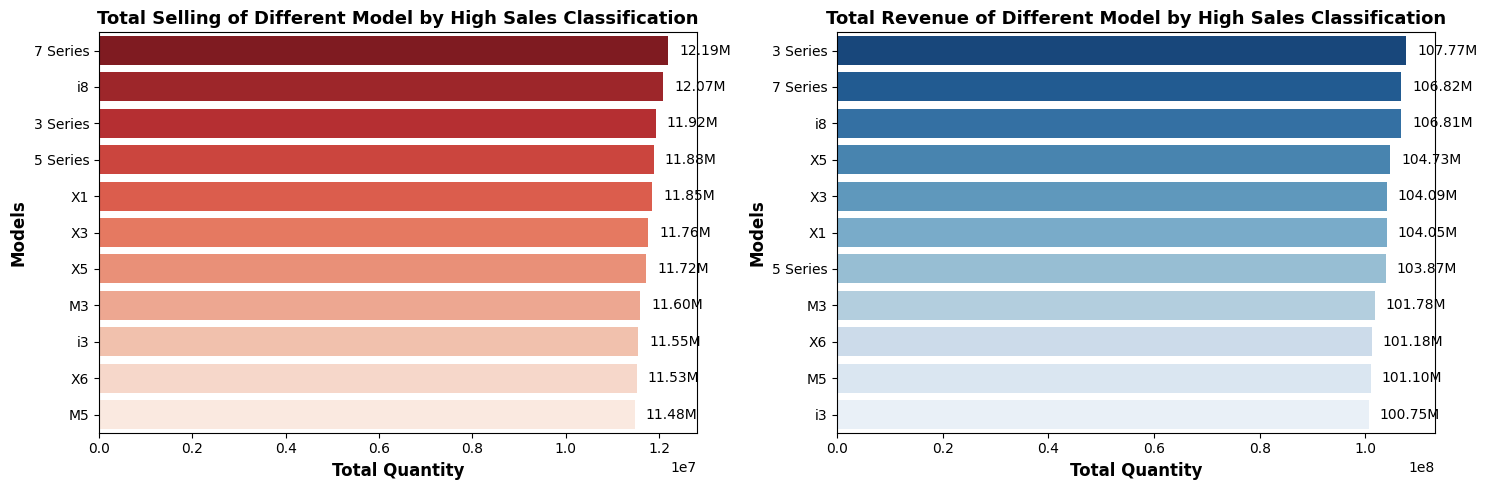

In [17]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.barplot(high_volume,x='total',y='Model',palette='Reds_r')
plt.title("Total Selling of Different Model by High Sales Classification",fontdict={'weight':'bold','size':13})
plt.xlabel("Total Quantity",fontsize=12,fontweight='bold')
plt.ylabel("Models",fontsize=12,fontweight='bold')
for bar in ax.patches:
    ax.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)

plt.subplot(1,2,2)
ax1 = sns.barplot(high_price,x='total',y='Model',palette='Blues_r')
plt.title("Total Revenue of Different Model by High Sales Classification",fontdict={'weight':'bold','size':13})
plt.xlabel("Total Quantity",fontsize=12,fontweight='bold')
plt.ylabel("Models",fontsize=12,fontweight='bold')
for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)


plt.tight_layout()
plt.show()

In [146]:
high_mg_sales = pd.read_sql_query("""
                    SELECT Model, SUM(Sales_Volume) AS total
                    FROM bmw
                    WHERE (Mileage_KM > Price_USD)
                    GROUP BY Model
                    ORDER BY total DESC
                    """,conn)
high_mg_sales

,Model,total
0,7 Series,15060354
1,5 Series,14786726
2,X1,14680278
3,M5,14622862
4,i8,14524357
5,3 Series,14443126
6,X3,14374381
7,X6,14253401
8,i3,14201040
9,X5,14047312


In [147]:
high_mg_rev = pd.read_sql_query("""
                    SELECT Model, SUM(Price_USD) AS total
                    FROM bmw
                    WHERE (Mileage_KM > Price_USD)
                    GROUP BY Model
                    ORDER BY total DESC
                    """,conn)
high_mg_rev

,Model,total
0,7 Series,205241259
1,5 Series,205223229
2,M5,199936855
3,X1,199554166
4,3 Series,198865583
5,X3,197984388
6,i3,197011100
7,i8,196218765
8,X5,195304834
9,X6,192900564


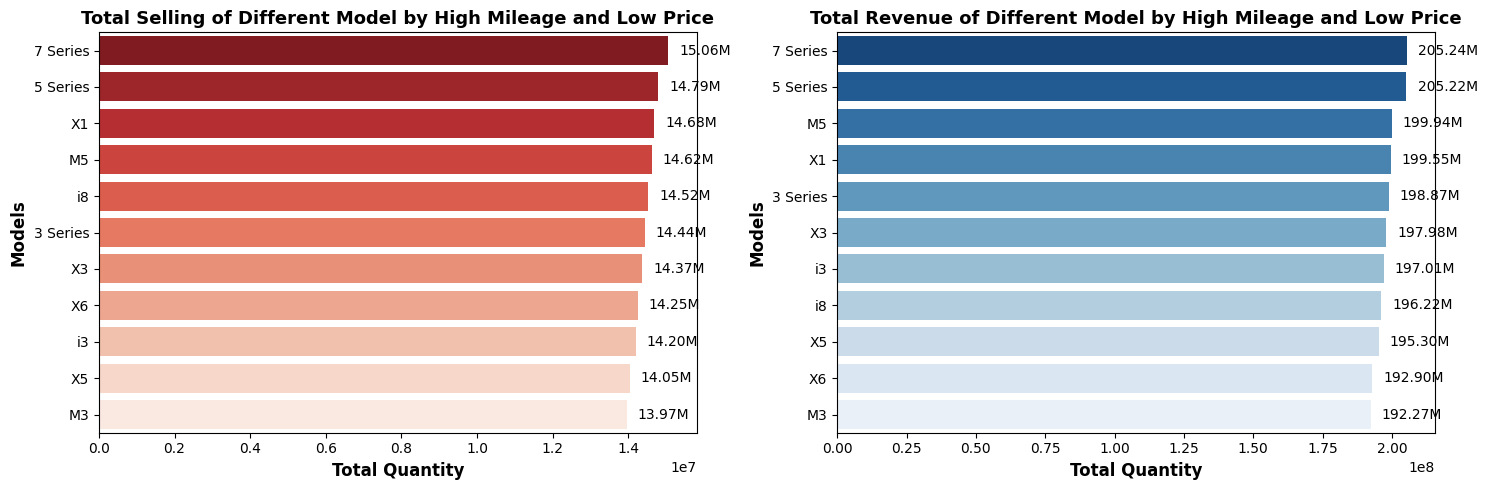

In [149]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.barplot(high_mg_sales,x='total',y='Model',palette='Reds_r')
plt.title("Total Selling of Different Model by High Mileage and Low Price",fontdict={'weight':'bold','size':13})
plt.xlabel("Total Quantity",fontsize=12,fontweight='bold')
plt.ylabel("Models",fontsize=12,fontweight='bold')
for bar in ax.patches:
    ax.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)

plt.subplot(1,2,2)
ax1 = sns.barplot(high_mg_rev,x='total',y='Model',palette='Blues_r')
plt.title("Total Revenue of Different Model by High Mileage and Low Price",fontdict={'weight':'bold','size':13})
plt.xlabel("Total Quantity",fontsize=12,fontweight='bold')
plt.ylabel("Models",fontsize=12,fontweight='bold')
for bar in ax1.patches:
    ax1.text(bar.get_width() + (bar.get_width()*0.02),
           bar.get_y() + (bar.get_height()/2),
           value_change(bar.get_width()),
           ha='left',va='center',fontsize=10)


plt.tight_layout()
plt.show()

In [29]:
avg_price = pd.read_sql_query("""
                SELECT Model, ROUND(AVG(Price_USD),0) AS price
                FROM bmw
                WHERE (Sales_Classification = 'High') & (Mileage_KM > Price_USD)
                GROUP BY Model
                ORDER BY price
                """,conn)
avg_price

,Model,price
0,7 Series,68296.0
1,i3,68472.0
2,i8,69249.0
3,M3,69314.0
4,5 Series,69467.0
5,X3,69755.0
6,X1,69887.0
7,M5,69926.0
8,X6,70046.0
9,X5,70639.0


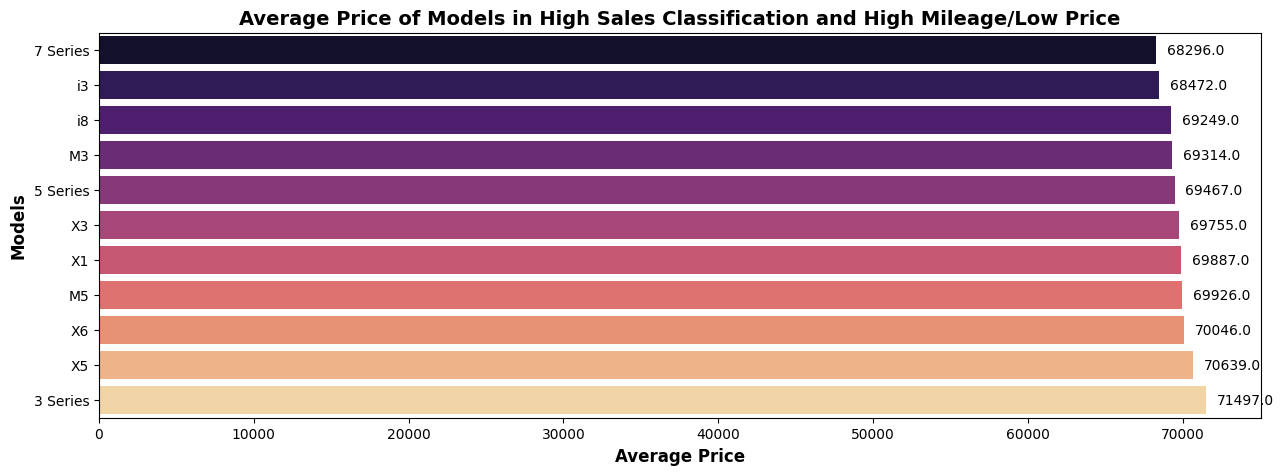

In [32]:
plt.figure(figsize=(15,5))

ax = sns.barplot(avg_price,y='Model',x='price',palette='magma')
plt.title("Average Price of Models in High Sales Classification and High Mileage/Low Price",fontdict={'weight':'bold','size':14})
plt.xlabel("Average Price",fontsize=12,fontweight='bold')
plt.ylabel("Models",fontweight='bold',fontsize=12)

for bar in ax.patches:
    ax.text(bar.get_width() + (bar.get_width()*0.01),
           bar.get_y() + (bar.get_height()/2),
           bar.get_width(),
           ha='left',va='center',fontsize=10)

plt.show()

In [29]:
pd.read_sql_query("""
                    SELECT Model, Transmission, Engine_Size_L, Fuel_Type, Color, SUM(Sales_Volume) AS total
                    FROM bmw                    
                    GROUP BY 1, 2, 3, 4, 5
                    ORDER BY total DESC
                    LIMIT 5
                    """,conn)

,Model,Transmission,Engine_Size_L,Fuel_Type,Color,total
0,M5,Automatic,3.9,Electric,Blue,70294
1,X1,Automatic,4.8,Hybrid,Silver,65807
2,7 Series,Automatic,3.9,Diesel,Grey,63071
3,7 Series,Manual,1.8,Hybrid,Black,62517
4,i8,Manual,3.2,Petrol,Silver,57720


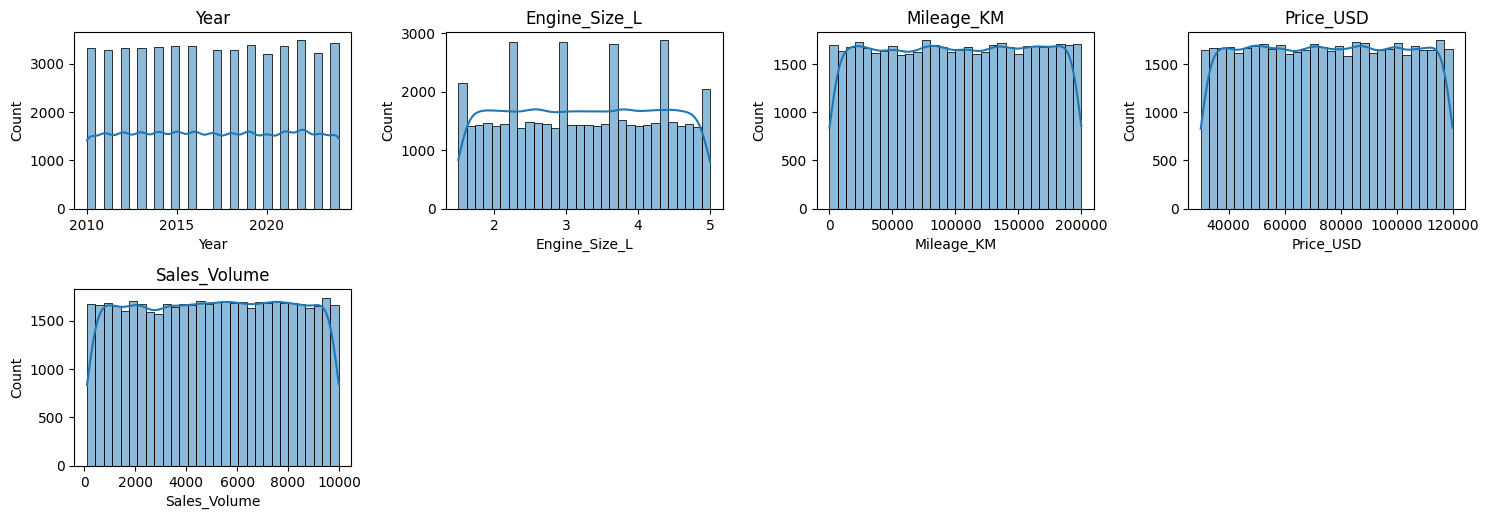

In [130]:
# Distribution Plots for Numberical Columns
numercial_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numercial_cols):
    plt.subplot(4,4, i+1) # Adjust grid layout as needed
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

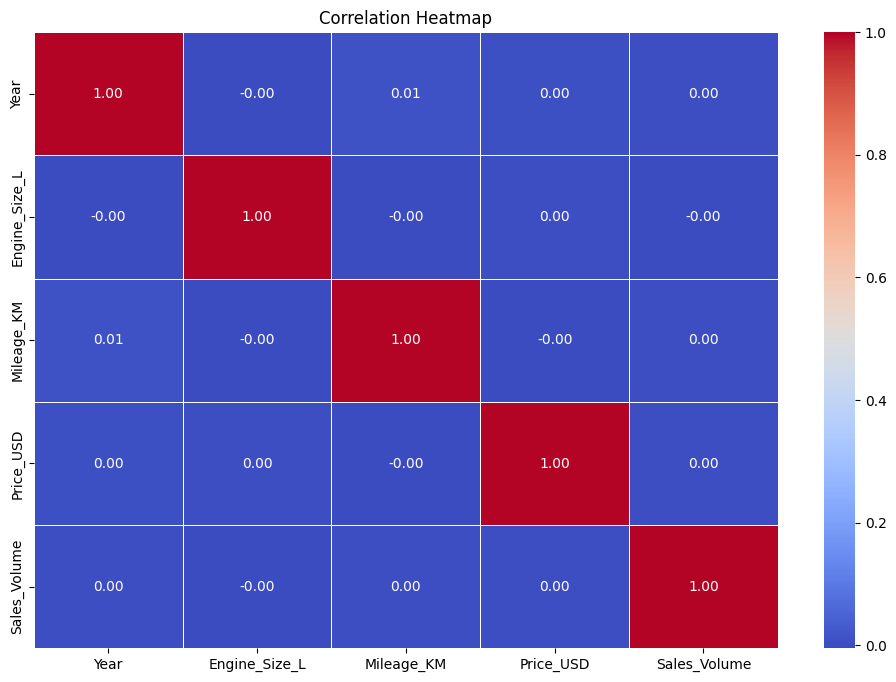

In [132]:
# Correlation Heatmap
plt.figure(figsize=(12,8))
correlation_matrix = df[numercial_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [71]:
pd.read_sql_query("""
                    SELECT Model, Region, Transmission, Fuel_Type, Color, Engine_Size_L, Price_USD, Sales_Classification
                    FROM bmw
                    ORDER BY Price_USD DESC
                    LIMIT 1
                    """,conn)

,Model,Region,Transmission,Fuel_Type,Color,Engine_Size_L,Price_USD,Sales_Classification
0,i8,Middle East,Manual,Electric,Silver,4.2,119998,Low


<h4>BMW Sales Summary</h4>
<p><b>7 Series</b> is the most highly demanded model and also high revenue generated model across all models.<br>
<b>Asia</b> holds largest shares of BMW Models.<br>
<b>Hybrid Fuel</b> with <b>Manual Transmission</b> are the most frequent model.<br>
<b>Red</b> Color is most common color across models.<br> 
<b>1.9L</b> Engine is the most selling engine for BMW models.<br>
<b>2022</b> Year is highest selling year for BMW Models.<br>
<b>M5 Series</b> Model is the highest Mileage/KM model 75,566.23<br>
<b>7 Series</b> Model is the highest Average Price model 75570.19<br>
<b>i8 (Manual Electric Silver 4.2L)</b> of Middle East Region Model is the most expensive model, despite low sales classfication<br></p>

<h4>Special Highlights</h4>
<p><b>7 Series</b> is the Top selling model in High Sales Classification.<br>
    <b>7 Series</b> dominates total sales volume with 9.39%.<br>
    <b>7 Series</b> is the Second most revenue generating model in high sales classification.<br>
    <b>7 Series</b> is the top model in high mileage and low price comarison.<br>
    <b>7 Series</b> is the top in revenue generating model in high mileage and low price comarison.<br>
    <b>7 Series</b> is in top position whose average Price is lower in high sales classification where mileage is higher and price is lower.<br>
    <b>2017</b> is the top selling year for <b>7 Series</b> Model.<br>
    <b>North America</b> is the largest continent for selling <b>7 Series</b> Model.<br>
    <p>Company has to focus on better mileage and better price for each model to increase sales.</p><br>
</p>

#### Regional Preferences
<ul>
    <li>Transmission:</li>
    <ul>
        <li>Asia → Manual</li>
        <li>Africa → Automatic</li>
        <li>Europe → Manual</li>
        <li>Middle East → Manual</li>
        <li>North America → Automatic</li>
        <li>South America → Manual</li>
    </ul></ul>
<ul>
    <li>Fuel Type:</li>
    <ul>
        <li>Africa → Petrol</li>
        <li>Asia → Hybrid</li>
        <li>Europe → Hybrid</li>
        <li>Middle East → Petrol</li>
        <li>North America → Electric</li>
        <li>South America → Diesel</li></ul>        
</ul>

#### Engine Size Insights:
<ul>
        <li><b>1.9L</b> and <b>4.5L</b> are highly demanded.</li>
        <li><b>1.9L</b> → <b>Europe</b>, especially for <b>X6</b> and <b>M5</b> Model</li>
        <li><b>4.5L</b> → <b>Asia</b>, especially for <b>7 Series</b> and <b>X1</b> Model</li>
</ul>

#### Yearly & Market Trends
<ul>
    <li>2022 recorded the highest total sales volume and X5 is the top selling model with 1796846 Selling Units.</li>
    <li>in 2022, Europe achieved the highest sales volume.</li>
    <li>Hybrid Model is highly demanded Model in 2022</li>
    <li>Europe leads globally with 17.27% of the total selling price in 2022.</li>
</ul>
